# Ridge regression using grid search CV 
The following code is highly inspired by "https://github.com/fnauman/timeseries/blob/master/candydata/xgboost_pipeline_candy.ipynb" but modified to fit our data. The times series handling and use of TimeSeriesSplit is confirmed by https://github.com/carl24k/fight-churn.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

In [18]:
# Defining different measures to evaluate performance 
# MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-8): 
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100 

mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

# SMAPE
def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

smape = make_scorer(symmetric_mape, 
                    greater_is_better=False)

def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [171]:
# Load in the time series
candy = pd.read_csv('dfV3.csv')
# Set the index equal to time stamp
candy["Unnamed: 0"] = pd.to_datetime(candy["Unnamed: 0"])
candy = candy.set_index('Unnamed: 0')


KeyError: 'DK1'

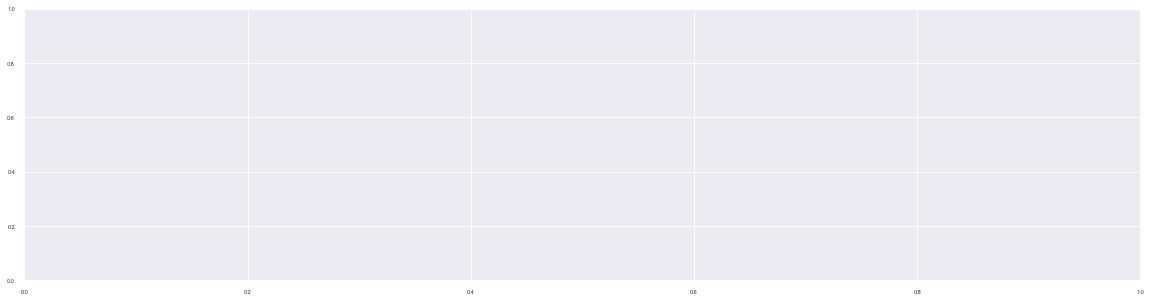

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (20,5))
sns.color_palette("vlag", as_cmap=True)
sns.set(font_scale = 0.5)
candy["negDK1"] = -candy["DK1"]
sns.heatmap(pd.DataFrame(candy.corr()["DK1"]).sort_values(by = "DK1", ascending = False).T, fmt="g", cmap='vlag')

plt.show()

In [172]:
# Split the data into a train and test set
df_train, df_test = candy.iloc[:-9341], candy.iloc[-9341:]

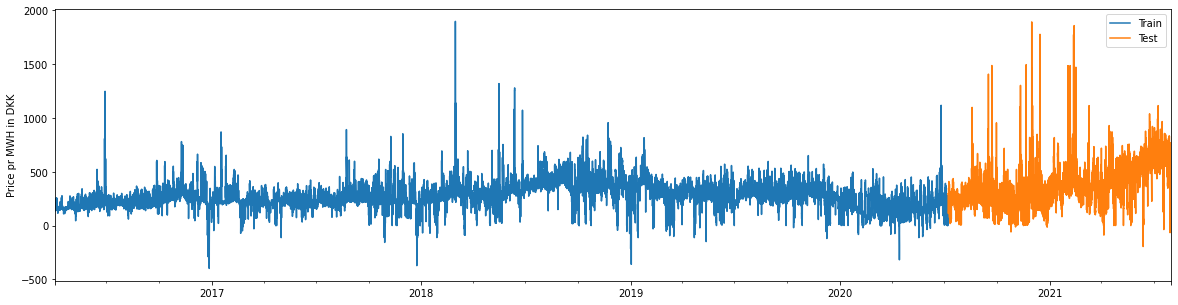

In [ ]:
# Create plot visualizing the train and test data 

# Create an axis
fig, ax = plt.subplots(figsize = (20,5))

# Plot the train and test setsa dn show
df_train["DK2"].plot(ax=ax)
df_test["DK2"].plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
ax.set_xlabel("")
ax.set_ylabel("Price pr MWH in DKK")
plt.show()

In [21]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK2"]].to_numpy()
y_test  = df_test[["DK2"]].to_numpy()

X_train = df_train.copy()
X_test  = df_test.copy()

X_train.drop('DK2', inplace=True, axis=1)
X_test.drop('DK2', inplace=True, axis=1)

X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()

In [152]:
# Define the pipeline for the Lasso regression
pipe_ridge = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('ridge', Ridge())
                       ])

# Set the different values of lambdas to be searched through in the CV
params_ridge = {'ridge__alpha': np.logspace(-4,10,20)}

In [192]:
# Define the type of cross validation used in the grid search. The TimesSeriesSplit 
# is the k-fold alternative for times series keeping the natural order in the data 
# i.e. one avoid using future observations to predict the past. 
ts_cv = TimeSeriesSplit(n_splits=20).split(X_train_new)

# Define the pipeline for the grid search using the LASSO pipeline and defined type of CV.
# Further, we apply the relevant scoring and parallelizes the CV
gs_ridge = GridSearchCV(pipe_ridge,
                        param_grid=params_ridge,
                        scoring='neg_mean_squared_error',
                        cv=ts_cv,
                        n_jobs=4)

In [180]:

ts_cv = TimeSeriesSplit(n_splits=20).split(X_train)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_ridge,
                   X=X_train_new,
                   y=y_train,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_absolute_error',                 
                   cv=ts_cv)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

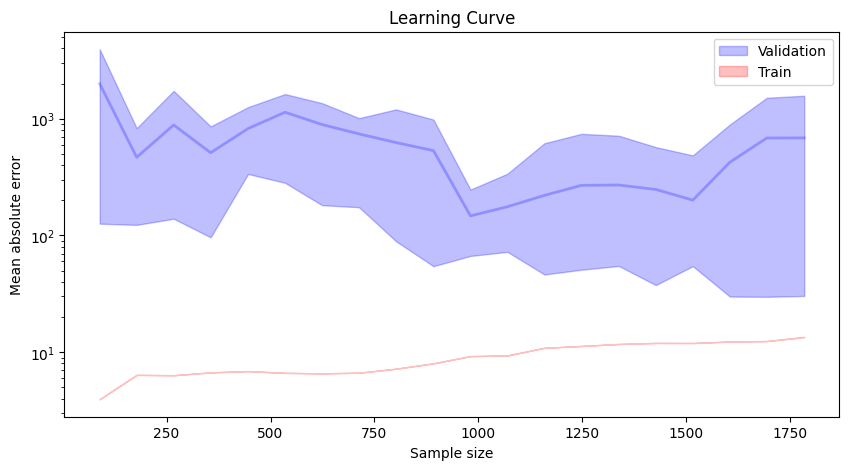

In [181]:
f_learn, ax = plt.subplots(figsize=(10,5))
ax.plot(train_sizes,-test_scores.mean(1), alpha=0.25, linewidth=2, color='blue', label='_nolegend_') # negated, because we already use neg_MSE
ax.fill_between(train_sizes, -test_scores.min(1), -test_scores.max(1), alpha=0.25, label ='Validation', color='blue')

ax.fill_between(train_sizes, -train_scores.min(1), -train_scores.max(1),  alpha=0.25, label='Train', color='red')

ax.set_title('Learning Curve')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Sample size')
ax.set_yscale('log')
ax.legend(['Validation', 'Train'])


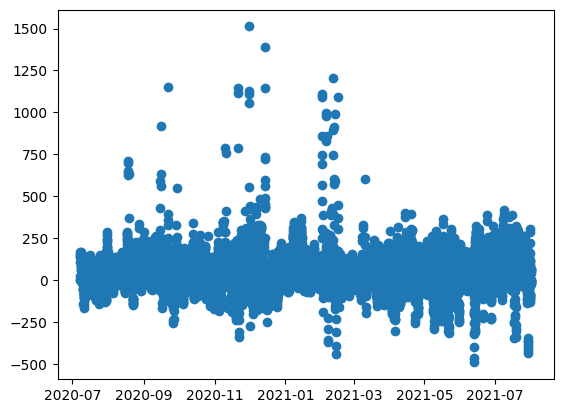

In [183]:
errors = y_test - y_pred_ridge
plt.scatter(df_test.index,errors)

In [185]:
ts_cv = TimeSeriesSplit(n_splits=20).split(X_train)

# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_ridge,
                     X=X_train,
                     y=y_train,
                     param_name='ridge__alpha',
                     param_range=np.logspace(-4,10,20),
                     scoring='neg_mean_squared_error',                 
                     cv=ts_cv,
                     n_jobs = 4)


In [186]:

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':np.logspace(-4,10,20)})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
428.13324    4069.473102
Name: Validation, dtype: float64


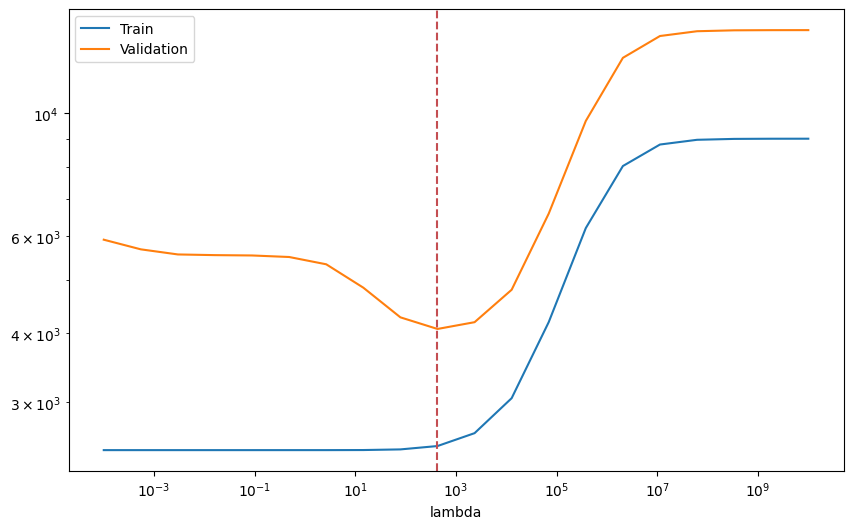

In [187]:
mse_score.plot(logx=True, logy=True, figsize=(10,6))
plt.axvline(mse_score.Validation.nsmallest(1).index, color='r', linestyle='dashed');

In [184]:
mse_score

,Train,Validation
lambda,,
1.000000e-04,29.917355,84.751784
5.455595e-04,29.917352,84.751229
2.976351e-03,29.917339,84.748199
1.623777e-02,29.917267,84.731676
8.858668e-02,29.916872,84.641777
4.832930e-01,29.914748,84.158459
2.636651e+00,29.904127,81.717675
1.438450e+01,29.866387,72.411666
7.847600e+01,29.795928,56.490448


In [ ]:
# Show which observations that go into train and validation sets
# ts_cv = TimeSeriesSplit(n_splits=15, test_size=1)
# for train_index, test_index in ts_cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index)


In [131]:
not_list = ['acc_precip',
'temp_grass',
'DK1 - DK2.L.24',
'DK - DE.L.24',
'cloud_cover',
'temp_soil_max_past1h',
'mean_relative_hum',
'DK1_CP',
'DK1_PP',
'DK1_WP',
'DK1 net exchange.L.24',
'DK2 net exchange.L.24',
'mean_wind_dir']

In [175]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK2"]].to_numpy()
y_test  = df_test[["DK2"]].to_numpy()

X_train_new = df_train[df_train.columns[~(df_train.columns.isin(not_list))]].copy()
X_test_new  = df_test[df_test.columns[~(df_test.columns.isin(not_list))]].copy()

X_train_new.drop('DK2', inplace=True, axis=1)
X_test_new.drop('DK2', inplace=True, axis=1)

X_train_new = X_train_new.to_numpy()
X_test_new  = X_test_new.to_numpy()

In [194]:
# Using the defined pipeline to fit our training set
#gs_ridge.fit(X_train_new,y_train)
# And predicting using the LASSO regression model and the test data 
y_pred_ridge = gs_ridge.predict(X_test_new)

<ipython-input-87-2fca88303292>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = y_pred_ridge


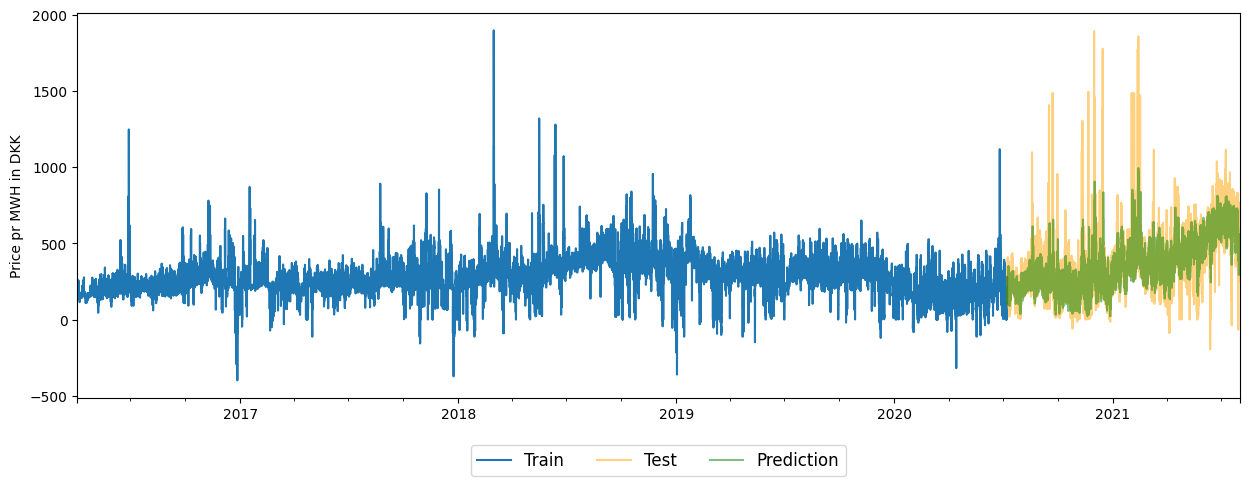

In [87]:
# Plot the actual values (train and test) and predicted valuesw
fig, ax = plt.subplots(figsize = (15,5))
plt.style.use('default')
df_train["DK2"].plot(ax=ax)
df_test["DK2"].plot(alpha = 0.5, color = "orange", ax=ax)

df_test["pred"] = y_pred_ridge
df_test["pred"].plot(alpha = 0.5, color = "green", ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Price pr MWH in DKK")
ax.legend(["Train","Test","Prediction"],loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, ncol=3, fontsize = 12);
plt.show()

In [195]:
# Optimal lambda value from the grid search
print(f"Optimal lambda value in ridge using grid search: {gs_ridge.best_params_}")

# Different scoring values
print_scores(y_test, y_pred_ridge)

Optimal lambda value in ridge using grid search: {'ridge__alpha': 428.1332398719387}
R2 score: 0.6815250685355667
MSE score: 12478.318648145381
MAE score: 73.78009437275385
Median AE score: 54.31085897614196
MAPE score: inf
SMAPE score: 13.811455562335015


<ipython-input-18-210cddad21fd>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100


In [34]:
# Defining the final pipeline using the optimal lambda detected from the grid search 
finalpipe_ridge = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('ridge', Ridge(alpha = gs_ridge.best_params_["ridge__alpha"]))
                       ])

# Fitting the training data and predicting on the test data
finalpipe_ridge.fit(X_train,y_train)
finalpipe_ridge.predict(X_test)

array([[167.99258639],
       [161.96804829],
       [154.1556592 ],
       ...,
       [533.13735181],
       [505.72772563],
       [491.21197201]])

In [35]:
# Save coefficients to a dictionary
candy.drop("DK2", inplace = True, axis = 1)
d = {}
for i in range(len(candy.columns)):
    d[candy.columns[i]] = list(finalpipe_ridge.named_steps['ridge'].coef_.T)[i][0]


In [49]:
d_new = pd.DataFrame(d.values()).T
d_new.columns = d.keys()

In [51]:
d_new.to_csv('ridge_coef.csv')

In [88]:
d_new

,cloud_cover,temp_soil_max_past1h,wind_max_per10min_past1h,acc_precip,bright_sunshine,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,mean_wind_dir,...,DK2.L.40,DK2.L.41,DK2.L.42,DK2.L.43,DK2.L.44,DK2.L.45,DK2.L.46,DK2.L.47,DK2.L.48,trend
0,0.162712,23.029324,-3.142979,-1.150559,2.620139,1.21171,-9.446996,-2.912223,-1.423339,-0.608617,...,0.051199,-0.720723,-0.748985,-0.277592,-0.065872,-0.373152,1.601708,1.495804,1.870339,15.164062
